# Importing necessary libraries

In [1]:
import kagglehub
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, create_map, lit
from pyspark.sql.functions import length, trim
from itertools import chain
from pyspark import SparkContext
from pyspark.sql.functions import length
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col, sum

# Importing dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("najzeko/steam-reviews-2021")

print("Path to dataset files:", path)

100%|██████████| 2.97G/2.97G [00:30<00:00, 103MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1


In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Steam Reviews Analysis") \
    .getOrCreate()

In [4]:
# Path to the dataset folder
dataset_path = "/root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1"

# Identify the CSV file
file_path = f"{dataset_path}/steam_reviews.csv"

# Load the data into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, multiLine=True, escape='"')

# Show a sample of the data
df.show(5)
# "schinese" is "simple chinese", "tchinese" is "traditional chinese"

+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|
+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-----

In our analysis we took a sample of the dataset due to runtime errors we got, since our machines could not process the amount of the original dataset (21 million records). Our sample consists of only the English reviews, which are around 9 million, and is still considered to be a dataset suitable for Big Data.

In [5]:
df.filter(df.language == "english").count()

9635437

In [6]:
df.filter(df.language == "english").write.parquet("sample_df", mode="overwrite")

In [7]:
sample_df = spark.read.parquet("/content/sample_df")

In [8]:
sample_df = sample_df.withColumn("review_length", length("review")) #create new column with the length of each review

In [9]:
sample_df.show(5)

+---+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------+
|_c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|review_length|
+---+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------

In [10]:
# spark.catalog.clearCache() if PySpark cached an earlier version of the data and still reference outdated records

##  **Exploratory Data Analysis**

In [11]:
# Rename the columns that have "." since we have errors in accessing them with their original name
sample_df = sample_df.withColumnRenamed("author.steamid", "author_steamid") \
                     .withColumnRenamed("author.num_games_owned", "author_num_games_owned") \
                     .withColumnRenamed("author.num_reviews", "author_num_reviews") \
                     .withColumnRenamed("author.playtime_forever", "author_playtime_forever") \
                     .withColumnRenamed("author.playtime_last_two_weeks", "author_playtime_last_two_weeks") \
                     .withColumnRenamed("author.playtime_at_review", "author_playtime_at_review") \
                     .withColumnRenamed("author.last_played", "author_last_played")

# Print the new column names
print(sample_df.columns)

['_c0', 'app_id', 'app_name', 'review_id', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'review_length']


We observed that certain columns are not informative for our objective, therefore we decided to keep only the relevant features.

In [12]:
# Keep only the relevant features
sample_df = sample_df.select("_c0","app_id","app_name","review_id","review","recommended","votes_helpful","steam_purchase","received_for_free","written_during_early_access","votes_helpful","author_steamid", "author_num_games_owned", "author_num_reviews", "author_playtime_forever", "author_playtime_at_review", "review_length")

View the first records of our dataset to understand the data that we have.

In [13]:
sample_df.show(5)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  3|292030|The Witcher 3: Wi...| 85184605|One of the best R...|       true|            0|          true|            false|       

Checking for null values and removing them.

In [14]:
# Count nulls in each column
null_counts = sample_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sample_df.columns])

# Display null counts for each column
null_counts.show()

+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+-------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|app_name|review_id|review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+-------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  0|     0|       0|        0| 16750|          0|            0|             0|                0|                          0|            0|             0|                     0|                 0|                     

In [15]:
# Drop rows with null values in any column
sample_df = sample_df.na.drop()

In [16]:
# Verify no nulls remain
sample_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sample_df.columns]).show()

+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+-------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|app_name|review_id|review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+-------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  0|     0|       0|        0|     0|          0|            0|             0|                0|                          0|            0|             0|                     0|                 0|                     

Calculate summary statistics regarding the time (in minutes) that users played the game at the moment of writing their review. Using those, we will categorize users into three main categories, according to whether they have played for little, medium, or much time.

In [17]:
sample_df.select("author_playtime_at_review").describe().show()

+-------+-------------------------+
|summary|author_playtime_at_review|
+-------+-------------------------+
|  count|                  9606842|
|   mean|        9143.312766567828|
| stddev|        26478.30080684629|
|    min|                      1.0|
|    max|                3228103.0|
+-------+-------------------------+



Similarly, we calculate summary statistics regarding the total playtime of users and we will categorize them into three categories according to the amount of time they played games in total.

In [18]:
sample_df.select("author_playtime_forever").describe().show()

+-------+-----------------------+
|summary|author_playtime_forever|
+-------+-----------------------+
|  count|                9606842|
|   mean|     16371.968813997357|
| stddev|      40908.99046628258|
|    min|                    0.0|
|    max|              3744943.0|
+-------+-----------------------+



In [19]:
# Create new columns for playtime categories
sample_df = sample_df.withColumn(
    "playtime_category",
    when(col("author_playtime_at_review") < 5000, "Low")
    .when((col("author_playtime_at_review") >= 5000) & (col("author_playtime_at_review") < 20000), "Medium")
    .otherwise("High")
)

sample_df = sample_df.withColumn(
    "playtime_forever_category",
    when(col("author_playtime_forever") < 5000, "Low")
    .when((col("author_playtime_forever") >= 5000) & (col("author_playtime_forever") < 20000), "Medium")
    .otherwise("High")
)

Use the aforementioned categories to visualize the number of users in each category, using barplots.

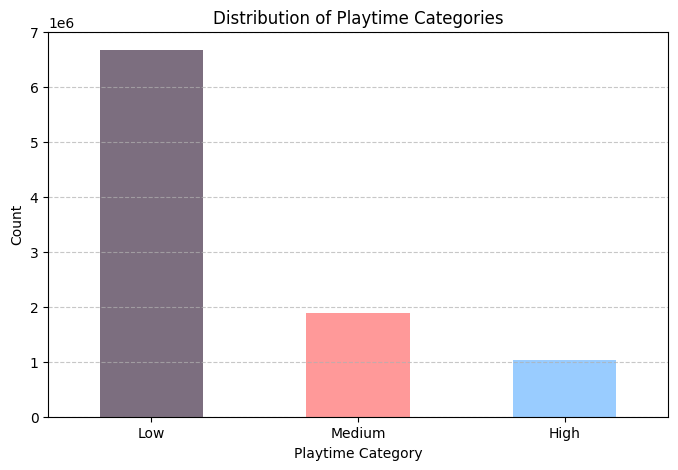

In [20]:
# Convert PySpark DataFrame to Pandas
pandas_df = sample_df.select("playtime_category").toPandas()

# Count occurrences of each category
category_counts = pandas_df["playtime_category"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["#7C6E7F", "#FF9999", "#99CCFF"])
plt.title("Distribution of Playtime Categories")
plt.xlabel("Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

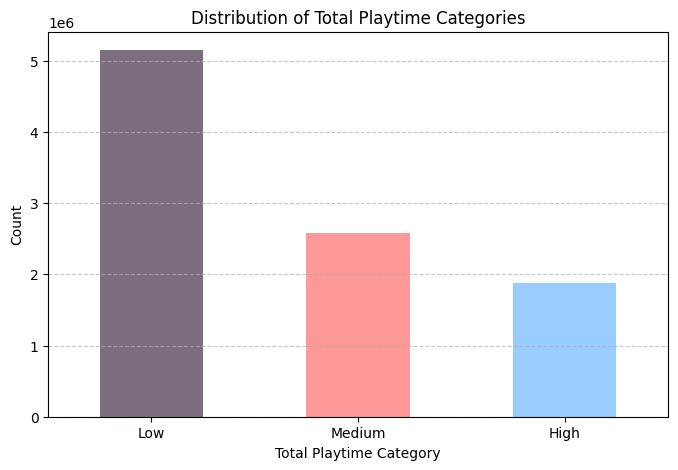

In [21]:
# Convert PySpark DataFrame to Pandas
pandas_df = sample_df.select("playtime_forever_category").toPandas()

# Count occurrences of each category
category_counts_forever = pandas_df["playtime_forever_category"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts_forever.plot(kind="bar", color=["#7C6E7F", "#FF9999", "#99CCFF"])
plt.title("Distribution of Total Playtime Categories")
plt.xlabel("Total Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

Check all the unique games in the reviews.

In [22]:
sample_df.select("app_name").distinct().show()

+--------------------+
|            app_name|
+--------------------+
|The Witcher 3: Wi...|
|    Dead by Daylight|
|Sid Meier's Civil...|
|            Portal 2|
|           Half-Life|
|Half-Life 2: Epis...|
|         Garry's Mod|
|           X Rebirth|
|Sid Meier's Civil...|
|Counter-Strike: S...|
|    Human: Fall Flat|
|      Umbrella Corps|
|Pogostuck: Rage W...|
|Momodora: Reverie...|
|         Down To One|
|                20XX|
|         Cold Waters|
|            NBA 2K18|
|      Super Meat Boy|
|            Identity|
+--------------------+
only showing top 20 rows



In [23]:
sample_df.groupBy("app_name").count().sort(col("count").desc()).show()  #sort in desc order to find apps with many reviews

+--------------------+------+
|            app_name| count|
+--------------------+------+
|Tom Clancy's Rain...|370120|
|            Terraria|369444|
|         Garry's Mod|330738|
|  Grand Theft Auto V|318809|
|PLAYERUNKNOWN'S B...|317529|
|            Among Us|294755|
|                Rust|283140|
|       Rocket League|248067|
|            PAYDAY 2|186532|
|ARK: Survival Evo...|183892|
|      Stardew Valley|172208|
|The Elder Scrolls...|159849|
|The Witcher 3: Wi...|151121|
|    Dead by Daylight|143613|
|           Fallout 4|138737|
|        Phasmophobia|129364|
|        No Man's Sky|116023|
|       Hollow Knight|109372|
|            Portal 2|106638|
|Sid Meier's Civil...|103931|
+--------------------+------+
only showing top 20 rows



<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 40857 (\N{CJK UNIFIED IDEOGRAPH-9F99}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-98f72faa4cd7>:12: UserWarning: Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from

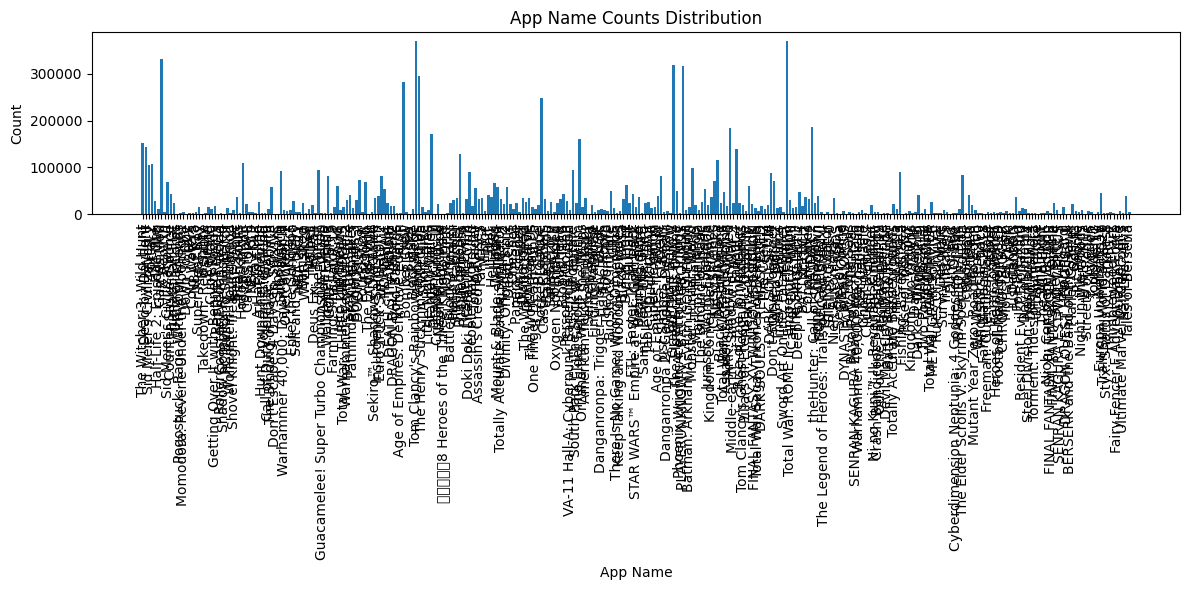

In [24]:
#The following plot is not very interpretable, due to the large number of app names

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("app_name").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['app_name'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("App Name")
plt.ylabel("Count")
plt.title("App Name Counts Distribution")
plt.tight_layout()
plt.show()


See how many users have purchased the app through Steam.

In [25]:
sample_df.groupBy("steam_purchase").count().show()

+--------------+-------+
|steam_purchase|  count|
+--------------+-------+
|          true|7421733|
|         false|2185109|
+--------------+-------+



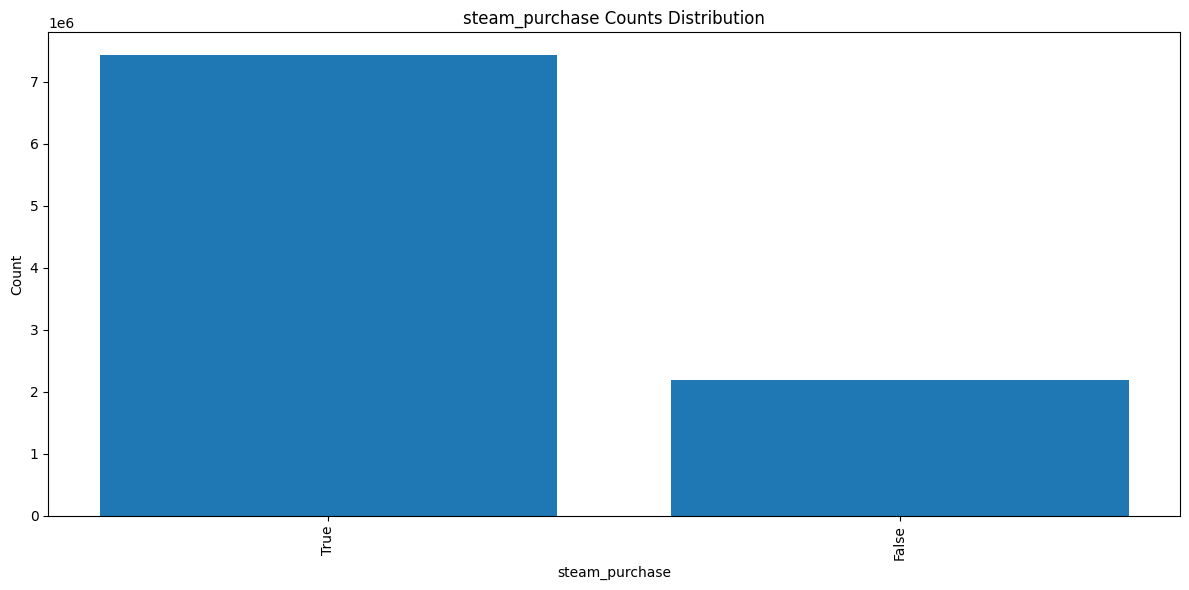

In [26]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("steam_purchase").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['steam_purchase'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("steam_purchase")
plt.ylabel("Count")
plt.title("steam_purchase Counts Distribution")
plt.tight_layout()
plt.show()


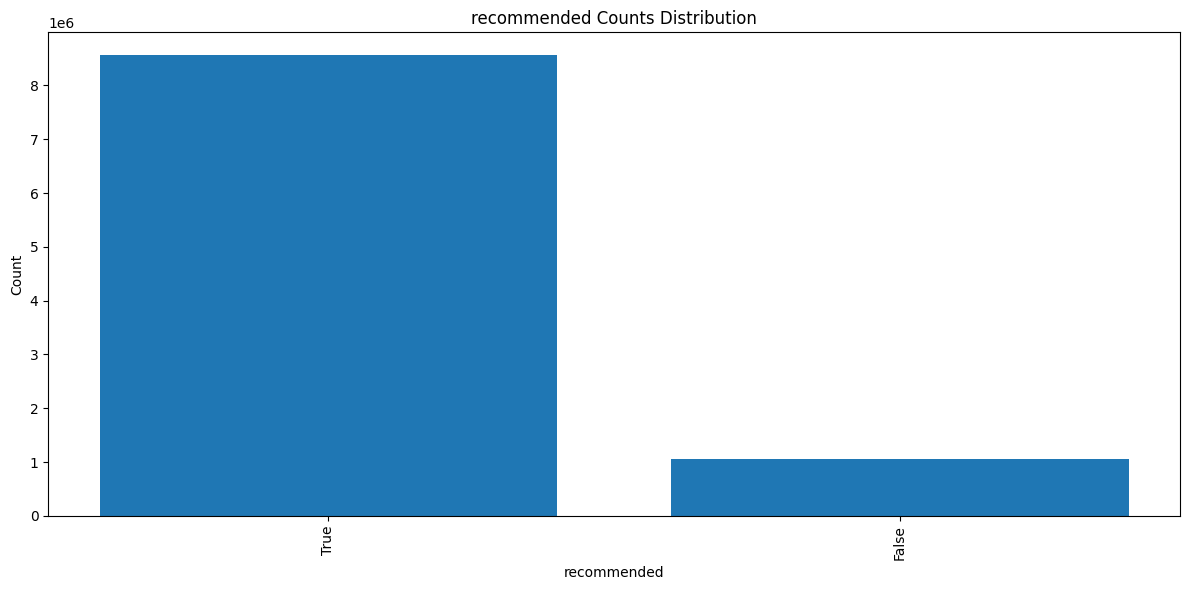

In [27]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("recommended").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['recommended'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("recommended")
plt.ylabel("Count")
plt.title("recommended Counts Distribution")
plt.tight_layout()
plt.show()


#we observe here that most reviews are positive - meaning they would recommend the app to other users

Check how many users have received the app for free.

In [28]:
sample_df.groupBy("received_for_free").count().show()

+-----------------+-------+
|received_for_free|  count|
+-----------------+-------+
|             true| 278731|
|            false|9328111|
+-----------------+-------+



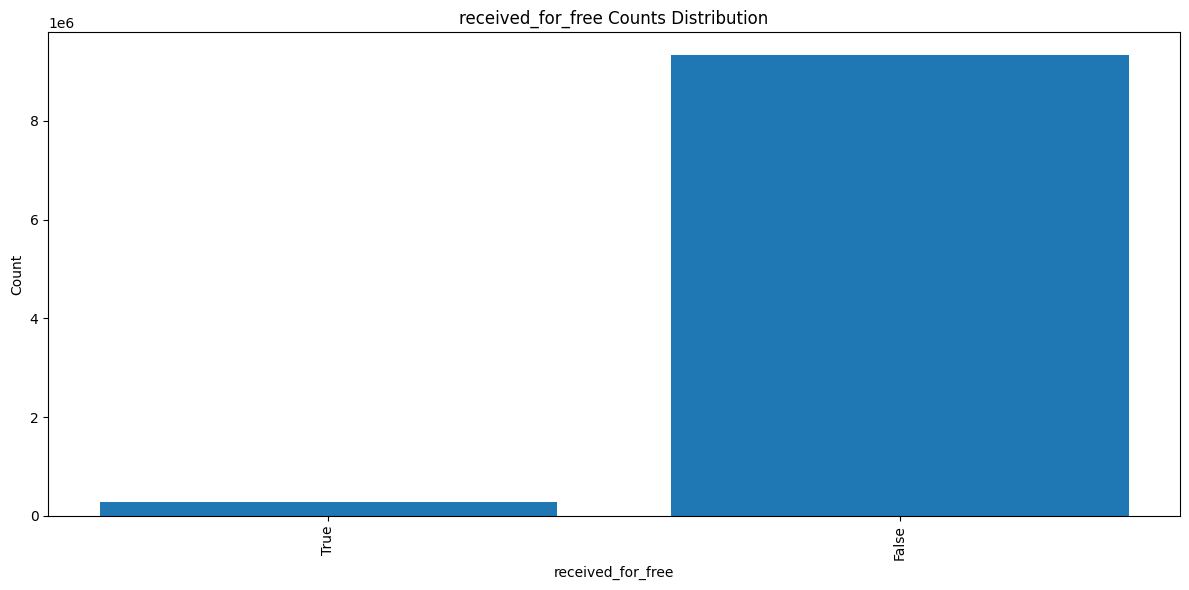

In [29]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("received_for_free").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['received_for_free'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("received_for_free")
plt.ylabel("Count")
plt.title("received_for_free Counts Distribution")
plt.tight_layout()
plt.show()

#most users did not receive the app for free

Check how many reiviews are written by users that purchased their app before the official release (early access).

In [30]:
sample_df.groupBy("written_during_early_access").count().show()

+---------------------------+-------+
|written_during_early_access|  count|
+---------------------------+-------+
|                      false|8650199|
|                       true| 956643|
+---------------------------+-------+



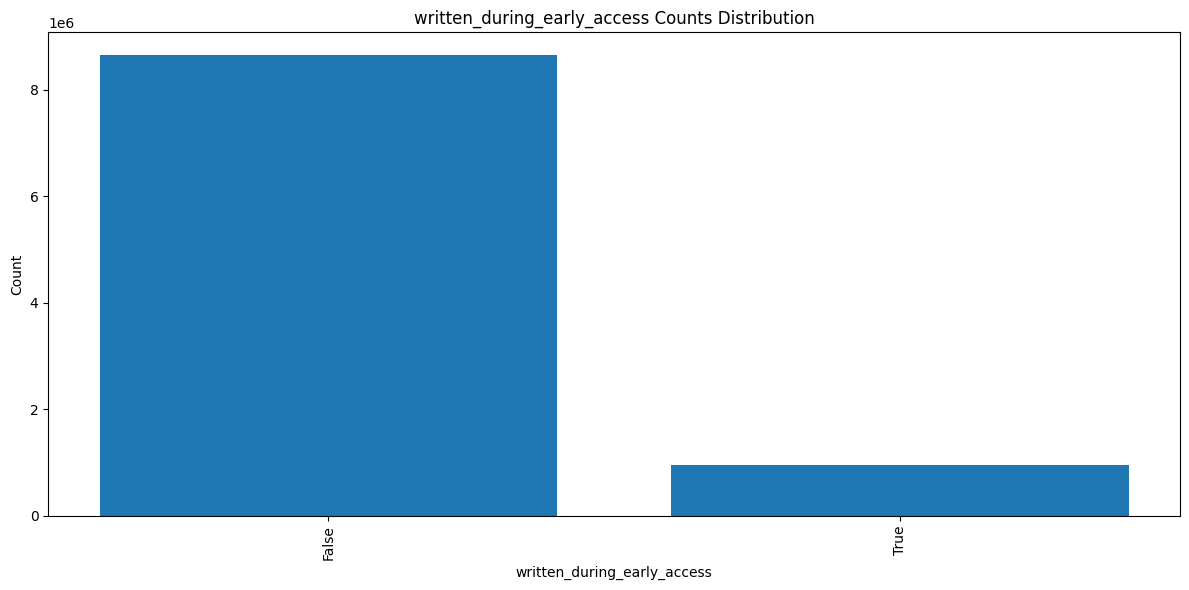

In [31]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("written_during_early_access").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['written_during_early_access'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("written_during_early_access")
plt.ylabel("Count")
plt.title("written_during_early_access Counts Distribution")
plt.tight_layout()
plt.show()


In [32]:
sample_df.groupBy("author_steamid").count().sort(col("count").desc()).show()   #sort in descending order to see the most frequent reviewers!

+-----------------+-----+
|   author_steamid|count|
+-----------------+-----+
|76561198062813911|  149|
|76561198315585536|  132|
|76561198045381877|  103|
|76561198064946151|  100|
|76561197969749884|   88|
|76561197997059777|   81|
|76561197990947284|   80|
|76561198048086581|   79|
|76561197999920602|   79|
|76561198166188807|   79|
|76561197970761123|   78|
|76561198011965365|   78|
|76561198038757354|   77|
|76561198112669681|   76|
|76561198094803808|   75|
|76561197986406741|   72|
|76561197999935168|   72|
|76561198057221241|   71|
|76561198266073876|   71|
|76561198082610824|   70|
+-----------------+-----+
only showing top 20 rows



# Bivariate analysis

We want to check if a user is more likely to recommend an app if they receive it for free

In [33]:
# Calculate total reviews and recommended true counts
pivot_table = df.groupBy('received_for_free').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = df.filter(df['recommended'] == True).groupBy('received_for_free').count().withColumnRenamed('count', 'Recommended (True)')

# Join the two DataFrames
pivot_table = pivot_table.join(recommended_true, 'received_for_free', 'left_outer')

# Calculate proportion
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.show()

+-----------------+-------------+------------------+----------------------+
|received_for_free|Total Reviews|Recommended (True)|Proportion Recommended|
+-----------------+-------------+------------------+----------------------+
|             true|       688061|            611033|    0.8880506234185632|
|            false|     21059310|          18411577|    0.8742725663851285|
+-----------------+-------------+------------------+----------------------+



As shown in the above table, the proportion of users who recieved the apps for free and would recommend them is roughly equal to the proportion of users who did not receive the apps for free and would recommend them.

To see if longer reviews are more positive or negative

In [37]:
# Calculate total reviews and recommended true counts for 'review_length'
pivot_table = sample_df.groupBy('review_length').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = sample_df.filter(sample_df['recommended'] == True).groupBy('review_length').count().withColumnRenamed('count', 'Recommended (True)')

# Join and calculate proportion
pivot_table = pivot_table.join(recommended_true, 'review_length', 'left_outer')
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.sort(col("review_length").desc()).show()  # to see longer reviews first




#NOTE: we can make a scatterplot of these values to check for correlation -- see cell below

+-------------+-------------+------------------+----------------------+
|review_length|Total Reviews|Recommended (True)|Proportion Recommended|
+-------------+-------------+------------------+----------------------+
|       150000|            1|              NULL|                  NULL|
|         8000|          862|               686|    0.7958236658932715|
|         7999|          300|               221|    0.7366666666666667|
|         7998|          134|                90|    0.6716417910447762|
|         7997|          119|                86|    0.7226890756302521|
|         7996|          117|                86|    0.7350427350427351|
|         7995|           68|                53|    0.7794117647058824|
|         7994|           89|                56|    0.6292134831460674|
|         7993|           65|                43|    0.6615384615384615|
|         7992|           68|                43|    0.6323529411764706|
|         7991|           65|                43|    0.6615384615

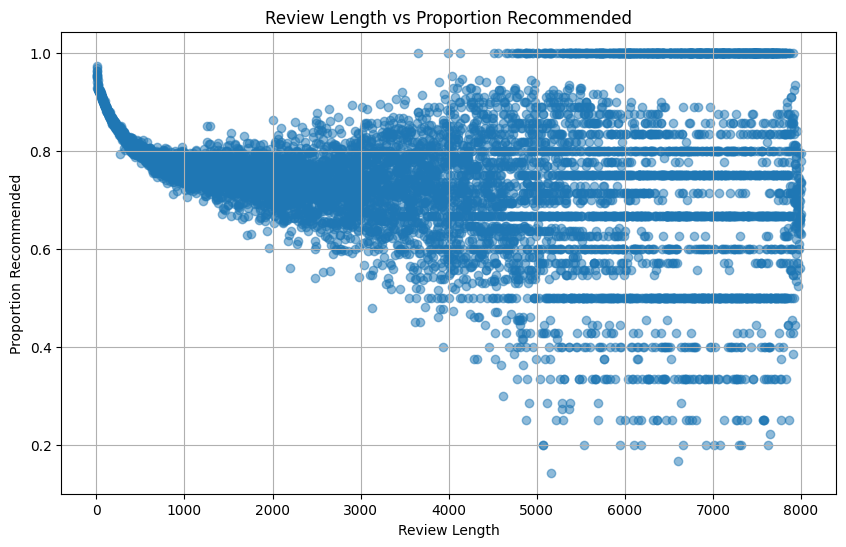

In [38]:
# Convert Spark DataFrame to Pandas for visualization
pivot_table_pd = pivot_table.select('review_length', 'Proportion Recommended').toPandas()

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table_pd['review_length'], pivot_table_pd['Proportion Recommended'], alpha=0.5)
plt.title('Review Length vs Proportion Recommended')
plt.xlabel('Review Length')
plt.ylabel('Proportion Recommended')
plt.grid(True)
plt.show()

Does higher playtime correlate with positive recommendations?

In [40]:
# Calculate total reviews and recommended true counts for 'author_playtime_at_review'
pivot_table = sample_df.groupBy('author_playtime_at_review').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = sample_df.filter(sample_df['recommended'] == True).groupBy('author_playtime_at_review').count().withColumnRenamed('count', 'Recommended (True)')

# Join and calculate proportion
pivot_table = pivot_table.join(recommended_true, 'author_playtime_at_review', 'left_outer')
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.sort(col("author_playtime_at_review").desc()).show()  # to see people who played for longer first


+-------------------------+-------------+------------------+----------------------+
|author_playtime_at_review|Total Reviews|Recommended (True)|Proportion Recommended|
+-------------------------+-------------+------------------+----------------------+
|                3228103.0|            1|                 1|                   1.0|
|                3062784.0|            1|                 1|                   1.0|
|                2773429.0|            1|                 1|                   1.0|
|                2395854.0|            1|                 1|                   1.0|
|                2281002.0|            1|                 1|                   1.0|
|                2262933.0|            1|              NULL|                  NULL|
|                2213127.0|            1|                 1|                   1.0|
|                2172346.0|            1|                 1|                   1.0|
|                2071808.0|            1|                 1|                

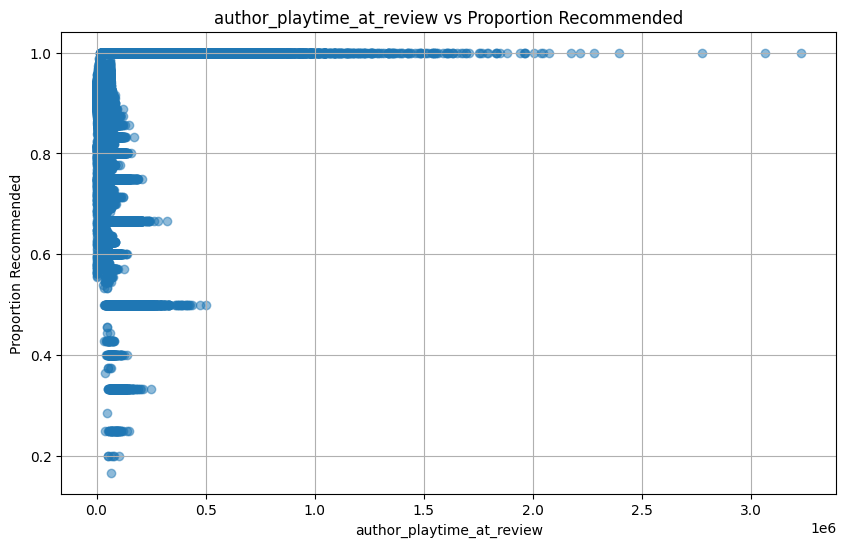

In [41]:
# Convert Spark DataFrame to Pandas for visualization
pivot_table_pd = pivot_table.select('author_playtime_at_review', 'Proportion Recommended').toPandas()

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table_pd['author_playtime_at_review'], pivot_table_pd['Proportion Recommended'], alpha=0.5)
plt.title('author_playtime_at_review vs Proportion Recommended')
plt.xlabel('author_playtime_at_review')
plt.ylabel('Proportion Recommended')
plt.grid(True)
plt.show()

Are frequent reviewers more positive or critical?

In [43]:
# Calculate total reviews and recommended true counts for 'author_num_reviews'
pivot_table = sample_df.groupBy('author_num_reviews').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = sample_df.filter(sample_df['recommended'] == True).groupBy('author_num_reviews').count().withColumnRenamed('count', 'Recommended (True)')

# Join and calculate proportion
pivot_table = pivot_table.join(recommended_true, 'author_num_reviews', 'left_outer')
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.sort(col("author_num_reviews").desc()).show()  # to see people who have made more reviews first


+------------------+-------------+------------------+----------------------+
|author_num_reviews|Total Reviews|Recommended (True)|Proportion Recommended|
+------------------+-------------+------------------+----------------------+
|     4398046511105|            1|                 1|                   1.0|
|              5236|           15|                15|                   1.0|
|              4137|           49|                40|    0.8163265306122449|
|              3775|            5|                 3|                   0.6|
|              3774|            2|                 2|                   1.0|
|              3772|            4|                 4|                   1.0|
|              3767|            1|                 1|                   1.0|
|              3766|            4|                 4|                   1.0|
|              3764|            3|                 2|    0.6666666666666666|
|              3762|            2|                 2|                   1.0|

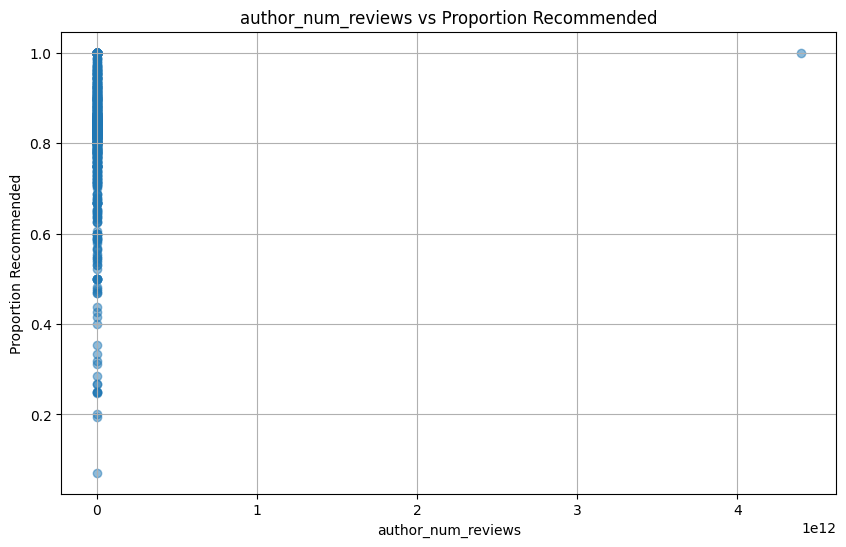

In [44]:
# Convert Spark DataFrame to Pandas for visualization
pivot_table_pd = pivot_table.select('author_num_reviews', 'Proportion Recommended').toPandas()

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table_pd['author_num_reviews'], pivot_table_pd['Proportion Recommended'], alpha=0.5)
plt.title('author_num_reviews vs Proportion Recommended')
plt.xlabel('author_num_reviews')
plt.ylabel('Proportion Recommended')
plt.grid(True)
plt.show()

Of those that received the app for free, how many reccomend the app?

In [45]:
df_pivot = sample_df.groupBy("received_for_free") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+-----------------+-----------------+----------------+
|received_for_free|recommended_false|recommended_true|
+-----------------+-----------------+----------------+
|             true|            30837|          247894|
|            false|          1017382|         8310729|
+-----------------+-----------------+----------------+



Of all the apps that are being reviewed, how many were purchased on Steam?

In [46]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("steam_purchase") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "steam_purchase_true") \
    .withColumnRenamed("false", "steam_purchase_false")

df_pivot.show()

+--------------------+--------------------+-------------------+
|            app_name|steam_purchase_false|steam_purchase_true|
+--------------------+--------------------+-------------------+
|    Human: Fall Flat|                8363|              16260|
|DRAGON BALL FighterZ|                4938|              11898|
|The Elder Scrolls...|               63504|              96345|
|      Umbrella Corps|                 743|                301|
|    Wallpaper Engine|                6634|              74055|
|          Nova Drift|                 359|               2132|
|           Detention|                 287|               1755|
|      SOULCALIBUR VI|                1727|               3287|
|The Witcher 3: Wi...|               13418|             137703|
|         GOD EATER 3|                 304|               1533|
|     Thief Simulator|                 183|               3387|
|The Legend of Her...|                 107|               1050|
|Ori and the Will ...|                 9

For each app, how many users have recommended it?

In [47]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+--------------------+-----------------+----------------+
|            app_name|recommended_false|recommended_true|
+--------------------+-----------------+----------------+
|    Human: Fall Flat|             1272|           23351|
|DRAGON BALL FighterZ|             1643|           15193|
|The Elder Scrolls...|            11616|          148233|
|      Umbrella Corps|              740|             304|
|    Wallpaper Engine|             1260|           79429|
|          Nova Drift|               41|            2450|
|           Detention|               71|            1971|
|      SOULCALIBUR VI|              910|            4104|
|The Witcher 3: Wi...|             3516|          147605|
|         GOD EATER 3|              214|            1623|
|     Thief Simulator|              480|            3090|
|The Legend of Her...|               43|            1114|
|Ori and the Will ...|              437|           13943|
|Danganronpa 2: Go...|              189|            7137|
|       STEINS

For each app, how many users have got it for free?

In [48]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("received_for_free") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "received_for_free_true") \
    .withColumnRenamed("false", "received_for_free_false")

df_pivot.show()

+--------------------+-----------------------+----------------------+
|            app_name|received_for_free_false|received_for_free_true|
+--------------------+-----------------------+----------------------+
|    Human: Fall Flat|                  23632|                   991|
|DRAGON BALL FighterZ|                  16430|                   406|
|The Elder Scrolls...|                 158545|                  1304|
|      Umbrella Corps|                    956|                    88|
|    Wallpaper Engine|                  77949|                  2740|
|          Nova Drift|                   2327|                   164|
|           Detention|                   2011|                    31|
|      SOULCALIBUR VI|                   4948|                    66|
|The Witcher 3: Wi...|                 149426|                  1695|
|         GOD EATER 3|                   1801|                    36|
|     Thief Simulator|                   3473|                    97|
|The Legend of Her..

For each app, how many reviews have been written from users that had early access?

In [49]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("written_during_early_access") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "written_during_early_access_true") \
    .withColumnRenamed("false", "written_during_early_access_false")

df_pivot.show()

+--------------------+---------------------------------+--------------------------------+
|            app_name|written_during_early_access_false|written_during_early_access_true|
+--------------------+---------------------------------+--------------------------------+
|    Human: Fall Flat|                            24623|                            NULL|
|DRAGON BALL FighterZ|                            16836|                            NULL|
|The Elder Scrolls...|                           159849|                            NULL|
|      Umbrella Corps|                             1044|                            NULL|
|    Wallpaper Engine|                            65517|                           15172|
|          Nova Drift|                             NULL|                            2491|
|           Detention|                             2042|                            NULL|
|      SOULCALIBUR VI|                             5014|                            NULL|
|The Witch

Of all the apps that have been purchased through Steam, how many are recommended?

In [50]:
df_pivot = sample_df.groupBy("steam_purchase") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+--------------+-----------------+----------------+
|steam_purchase|recommended_false|recommended_true|
+--------------+-----------------+----------------+
|          true|           784972|         6636761|
|         false|           263247|         1921862|
+--------------+-----------------+----------------+



How many apps did each user had early access on?


In [51]:
df_pivot = sample_df.groupBy("author_steamid") \
    .pivot("written_during_early_access") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "written_during_early_access_true") \
    .withColumnRenamed("false", "written_during_early_access_false")

df_pivot.show()

+-----------------+---------------------------------+--------------------------------+
|   author_steamid|written_during_early_access_false|written_during_early_access_true|
+-----------------+---------------------------------+--------------------------------+
|76561197960269579|                                8|                               1|
|76561197960272407|                                5|                            NULL|
|76561197960272423|                                5|                               2|
|76561197960272973|                                3|                               1|
|76561197960275854|                                2|                               2|
|76561197960277107|                                1|                            NULL|
|76561197960279691|                                1|                            NULL|
|76561197960292122|                                1|                            NULL|
|76561197960297361|                        

For each For each category of the playtime (up to the day of the review), how many users have reccomended the apps of the review?

In [52]:
df_pivot = sample_df.groupBy("playtime_category") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+-----------------+-----------------+----------------+
|playtime_category|recommended_false|recommended_true|
+-----------------+-----------------+----------------+
|             High|           124420|          913725|
|              Low|           729851|         5942612|
|           Medium|           193948|         1702286|
+-----------------+-----------------+----------------+



For each category of the total playtime, how many users have reccomended the apps of the review?

In [53]:
df_pivot = sample_df.groupBy("playtime_forever_category") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+-------------------------+-----------------+----------------+
|playtime_forever_category|recommended_false|recommended_true|
+-------------------------+-----------------+----------------+
|                     High|           196750|         1685163|
|                      Low|           627187|         4522579|
|                   Medium|           224282|         2350881|
+-------------------------+-----------------+----------------+



Of the apps that have been purchased during early access, how many are recommended?

In [54]:
df_pivot = sample_df.groupBy("written_during_early_access") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+---------------------------+-----------------+----------------+
|written_during_early_access|recommended_false|recommended_true|
+---------------------------+-----------------+----------------+
|                       true|           130263|          826380|
|                      false|           917956|         7732243|
+---------------------------+-----------------+----------------+



For each category of number of games owned, how many apps are recommended?

In [55]:
df_pivot = sample_df.groupBy("author_num_games_owned") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+----------------------+-----------------+----------------+
|author_num_games_owned|recommended_false|recommended_true|
+----------------------+-----------------+----------------+
|                    26|             5229|           60444|
|                  1677|               14|              86|
|                   474|              356|            1975|
|                  5385|             NULL|               6|
|                   964|               45|             330|
|                    29|             5228|           57980|
|                  2040|                7|              80|
|                  1806|                2|              19|
|                  2214|                7|              13|
|                  2927|                2|              24|
|                  1950|                1|              23|
|                  2250|             NULL|              24|
|                  3091|                1|               9|
|                  1697|                

# Recommendation System

In [56]:
sample_df.show(10)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|playtime_category|playtime_forever_category|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------

In [57]:
sample_df.select("recommended").distinct().show()

+-----------+
|recommended|
+-----------+
|       true|
|      false|
+-----------+



In [58]:
# Identify distribution in the 'recommended' column
sample_df.groupBy('recommended').count().show()

+-----------+-------+
|recommended|  count|
+-----------+-------+
|       true|8558623|
|      false|1048219|
+-----------+-------+



We observe a significant class imbalance (true: 8.58M and false: 1.05M) and hence, we proceed with 3% for Dominant Class & 10% for Minority Class (balanced reduction).


We tried using a stratified approach but the stratified df was returning 0 rows (.sampleBy() may fail if the specified fraction is too small to select records from a partition).

```python
# Define sampling fractions for each category
fractions = {"true": 0.03, "false": 0.10}  # Stratified sampling with balanced reduction

# Perform stratified sampling
stratified_sample = sample_df.sampleBy("recommended", fractions=fractions, seed=42)

# Show sampled data
stratified_sample.show(5)

# Count rows to verify sample size
print("Total Rows in Sample:", stratified_sample.count())
```

Hence, we proceeded with the sample() function.

In [59]:
# Sample 5% for balanced speed and accuracy
sample_df2 = sample_df.sample(fraction=0.20, seed=42)

sample_df2.show(5)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|playtime_category|playtime_forever_category|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------

In [60]:
sample_df2.groupBy('recommended').count().show()

+-----------+-------+
|recommended|  count|
+-----------+-------+
|       true|1713722|
|      false| 209144|
+-----------+-------+



### Pre-processing

In [61]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
from pyspark.sql import types as T

# Improved Mapping Function to Handle All Cases
def map_recommendation(value):
    if isinstance(value, str):
        value = value.strip().lower()  # Handle spaces and case issues
        if value in ["true", "1", "yes"]:   # Flexible matching for true
            return 1
        elif value in ["false", "0", "no"]: # Flexible matching for false
            return 0
    elif isinstance(value, bool):  # If values are directly boolean
        return 1 if value else 0
    return 0  # Default value for unexpected data

# Register UDF (User Defined Function)
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

map_recommendation_udf = udf(map_recommendation, T.IntegerType())

# Apply mapping logic
sample_df2_mappping = sample_df2.withColumn("recommended", map_recommendation_udf("recommended"))

In [62]:
# Check distribution after mapping
sample_df2_mappping.groupBy("recommended").count().show()

+-----------+-------+
|recommended|  count|
+-----------+-------+
|          1|1713722|
|          0| 209144|
+-----------+-------+



In [63]:
# separating the classes
majority_class = sample_df2_mappping.filter("recommended = 1")
minority_class = sample_df2_mappping.filter("recommended = 0")

# downsampling the majority class
ratio = minority_class.count() / majority_class.count()
downsampled_majority = majority_class.sample(False, ratio, seed=42)

# combining the downsampled majority and the original minority
balanced_data = downsampled_majority.union(minority_class)

In [64]:
# verifying class balance
balanced_data.groupBy("recommended").count().show()

+-----------+------+
|recommended| count|
+-----------+------+
|          1|209388|
|          0|209144|
+-----------+------+



In [65]:
# Index user and item IDs for collaborative filtering
user_indexer = StringIndexer(inputCol="author_steamid", outputCol="userId").fit(balanced_data) # we used to have "review_id" wrong.
item_indexer = StringIndexer(inputCol="app_id", outputCol="itemId").fit(balanced_data)

# Apply transformations
balanced_data = user_indexer.transform(balanced_data)
balanced_data = item_indexer.transform(balanced_data)

# Select relevant columns
data = balanced_data.select("userId", "itemId", "recommended")

In [66]:
data.write.mode("overwrite").parquet("/content/data")

In [67]:
data = spark.read.parquet("/content/data")

In [68]:
data.show(5)

+--------+------+-----------+
|  userId|itemId|recommended|
+--------+------+-----------+
|209882.0| 184.0|          0|
| 15931.0| 184.0|          0|
|139160.0| 184.0|          0|
|   482.0| 197.0|          0|
|327695.0| 197.0|          0|
+--------+------+-----------+
only showing top 5 rows



In [69]:
data.groupBy('recommended').count().show()

+-----------+------+
|recommended| count|
+-----------+------+
|          1|209388|
|          0|209144|
+-----------+------+



### Collaborative Filtering using ALS

In [70]:
# Split into train/test
(training_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

In [71]:
training_data.show()

+------+------+-----------+
|userId|itemId|recommended|
+------+------+-----------+
|   0.0|  26.0|          0|
|   0.0|  46.0|          0|
|   0.0|  99.0|          0|
|   0.0| 120.0|          0|
|   0.0| 195.0|          0|
|   1.0|  11.0|          0|
|   1.0| 120.0|          0|
|   1.0| 155.0|          0|
|   2.0|  22.0|          0|
|   2.0| 102.0|          0|
|   2.0| 221.0|          0|
|   3.0|  69.0|          0|
|   3.0|  98.0|          0|
|   3.0|  99.0|          0|
|   3.0| 160.0|          0|
|   4.0| 181.0|          0|
|   4.0| 206.0|          0|
|   4.0| 255.0|          0|
|   5.0| 216.0|          0|
|   6.0|  11.0|          0|
+------+------+-----------+
only showing top 20 rows



In [72]:
training_data.filter(col("userId") == 0.0).show()

+------+------+-----------+
|userId|itemId|recommended|
+------+------+-----------+
|   0.0|  26.0|          0|
|   0.0|  46.0|          0|
|   0.0|  99.0|          0|
|   0.0| 120.0|          0|
|   0.0| 195.0|          0|
|   0.0|  23.0|          0|
|   0.0|  52.0|          0|
|   0.0|  54.0|          0|
|   0.0|  91.0|          0|
|   0.0| 100.0|          0|
|   0.0| 172.0|          0|
+------+------+-----------+



In [73]:
# ALS

In [74]:
als = ALS(
    userCol="userId",
    itemCol="itemId",
    ratingCol="recommended",
    implicitPrefs=True,         # <- important!
    nonnegative=True,
    coldStartStrategy="drop",
    maxIter=10,
    regParam=0.1,
    rank=20
)

model = als.fit(training_data) # takes 4 mins with small sample

In [75]:
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="recommended", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse:.4f}")

Root-mean-square error = 0.5847


In [76]:
user_recs = model.recommendForAllUsers(10)

# Explode recommendations for readability
user_recs = user_recs.selectExpr("userId", "explode(recommendations) as rec") \
                     .selectExpr("userId", "rec.itemId as itemId", "rec.rating as predicted_score")

user_recs.show(10)

+------+------+---------------+
|userId|itemId|predicted_score|
+------+------+---------------+
|     1|    99|            0.0|
|     1|    98|            0.0|
|     1|    97|            0.0|
|     1|    96|            0.0|
|     1|    95|            0.0|
|     1|    94|            0.0|
|     1|    93|            0.0|
|     1|    92|            0.0|
|     1|    91|            0.0|
|     1|    90|            0.0|
+------+------+---------------+
only showing top 10 rows



since we see 0.0 above why is there not even a single 0.0 predicted score when i print the below?

or are they rounded to zeros?

In [77]:
user_recs.groupBy('predicted_score').count().show()

+---------------+-----+
|predicted_score|count|
+---------------+-----+
|    2.267511E-6|   21|
|    0.031291004|  860|
|     0.29093817|    1|
|    0.014850931| 1901|
|    0.006135369| 1060|
|   0.0014933996|  507|
|     0.27736363|    1|
|    0.013082908|  678|
|    0.028606664|    1|
|    0.006225986|    7|
|   6.8407814E-4|   66|
|    0.012543356| 1525|
|      0.4605072|    4|
|     0.03383468|    3|
|   0.0025839922|    1|
|   0.0014022148|    1|
|     0.23143281|    1|
|    0.023759883|    1|
|   0.0032866083|    1|
|     0.41426116|    1|
+---------------+-----+
only showing top 20 rows



In [78]:
user_recs.filter("predicted_score == 0.0").count()

1500170

In [79]:
user_recs.filter("userId == 1").show()


+------+------+---------------+
|userId|itemId|predicted_score|
+------+------+---------------+
|     1|    99|            0.0|
|     1|    98|            0.0|
|     1|    97|            0.0|
|     1|    96|            0.0|
|     1|    95|            0.0|
|     1|    94|            0.0|
|     1|    93|            0.0|
|     1|    92|            0.0|
|     1|    91|            0.0|
|     1|    90|            0.0|
+------+------+---------------+



In [80]:
user_recs.filter("userId == 100").show()


+------+------+---------------+
|userId|itemId|predicted_score|
+------+------+---------------+
|   100|    23|    0.001179014|
|   100|    15|    7.059766E-4|
|   100|    50|   6.9715985E-4|
|   100|    26|    6.913242E-4|
|   100|    16|   6.0458307E-4|
|   100|    22|    5.622228E-4|
|   100|    28|    5.272908E-4|
|   100|    41|   4.8064493E-4|
|   100|    62|    4.699941E-4|
|   100|    18|   4.4189303E-4|
+------+------+---------------+



why ???

In [81]:
# item-based

item_recs = model.recommendForAllItems(10)

item_recs = item_recs.selectExpr("itemId", "explode(recommendations) as rec") \
                     .selectExpr("itemId", "rec.userId as userId", "rec.rating as predicted_score")

item_recs.show(10)


+------+------+---------------+
|itemId|userId|predicted_score|
+------+------+---------------+
|     0|374090|      0.9585758|
|     0|372212|      0.9585758|
|     0|368071|      0.9585758|
|     0|367938|      0.9585758|
|     0|367320|      0.9585758|
|     0|367180|      0.9585758|
|     0|365651|      0.9585758|
|     0|365191|      0.9585758|
|     0|364660|      0.9585758|
|     0|364230|      0.9585758|
+------+------+---------------+
only showing top 10 rows



In [82]:
item_recs.filter("itemId = 1").show()
item_recs.filter("itemId = 2").show()

+------+------+---------------+
|itemId|userId|predicted_score|
+------+------+---------------+
|     1|363901|      0.9597491|
|     1|363171|      0.9597491|
|     1|362491|      0.9597491|
|     1|361164|      0.9597491|
|     1|361098|      0.9597491|
|     1|360990|      0.9597491|
|     1|360812|      0.9597491|
|     1|360571|      0.9597491|
|     1|360418|      0.9597491|
|     1|360221|      0.9597491|
+------+------+---------------+

+------+------+---------------+
|itemId|userId|predicted_score|
+------+------+---------------+
|     2|358612|      0.9604678|
|     2|358482|      0.9604678|
|     2|358342|      0.9604678|
|     2|358261|      0.9604678|
|     2|358230|      0.9604678|
|     2|357901|      0.9604678|
|     2|357767|      0.9604678|
|     2|357717|      0.9604678|
|     2|357371|      0.9604678|
|     2|357341|      0.9604678|
+------+------+---------------+



To generate game recommendations based on user behavior, we implemented collaborative filtering using the ALS (Alternating Least Squares) algorithm. We trained the ALS model on a user-item matrix where each row indicates whether a user recommended a game. The model learns latent user and item features that best predict the observed preferences.

After training, we generated:

User-based recommendations: Top 10 games predicted for each user.

Item-based recommendations: Top 10 users likely to enjoy each game.

We also evaluated the model using RMSE on the test data.

**ALS does not work well with binary (0 or 1), better with ratings.**

For each item (e.g. itemId = 1, itemId = 2), all predicted scores for the top 10 users are:

- Exactly the same for a given item

- But different between items

Why This Happens:
This is a known behavior in ALS when:

- The item latent vector is strongly dominant (i.e., item is popular / well-rated)

- Many users have very similar latent vectors

- The model has learned more about items than about users due to data imbalance or sparsity

So ALS ends up producing:

- One item score that aligns with many similar users

- Causing identical predicted_score values for different users of that item

What It Means:
- ALS is working — it's just that your users are not diverse enough in terms of behavior, or your dataset is too sparse to differentiate between them meaningfully

- It makes recommendations less personalized and more item-driven

## Collaborative Filtering Logistic Regression

In [83]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Encode user_id and item_id
user_indexer = StringIndexer(inputCol="author_steamid", outputCol="userIndex")
item_indexer = StringIndexer(inputCol="app_id", outputCol="itemIndex")

# Assemble features
assembler = VectorAssembler(inputCols=["userIndex", "itemIndex"], outputCol="features")

# Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="recommended", maxIter=10)

# Pipeline
pipeline = Pipeline(stages=[user_indexer, item_indexer, assembler, lr])

In [84]:
# Fit model
train_data, test_data = balanced_data.randomSplit([0.8, 0.2], seed=42)
lr_model = pipeline.fit(train_data)

In [85]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import DoubleType

In [86]:
# Create all user-item pairs (Cartesian product)
unique_users = balanced_data.select("userId").distinct()
unique_items = balanced_data.select("itemId").distinct()

user_item_pairs = unique_users.crossJoin(unique_items)
user_item_pairs = user_item_pairs \
    .withColumnRenamed("userId", "userIndex") \
    .withColumnRenamed("itemId", "itemIndex")

# UDF to extract probability of class 1
def extract_probability(prob_vector):
    return float(prob_vector[1])

extract_prob_udf = udf(extract_probability, DoubleType())

# Predict on all pairs
predictions = lr_model.transform(user_item_pairs)
# Apply the UDF to get the predicted score
predicted_scores = predictions.select("userIndex", "itemIndex", "probability") \
    .withColumn("predicted_score", extract_prob_udf(col("probability")))

In [87]:
predicted_scores.show()

+---------+---------+--------------------+-------------------+
|userIndex|itemIndex|         probability|    predicted_score|
+---------+---------+--------------------+-------------------+
| 137558.0|      7.0|[0.54182918449307...| 0.4581708155069204|
| 321489.0|      7.0|[0.33307909629054...| 0.6669209037094525|
| 294602.0|      7.0|[0.36163277648900...| 0.6383672235109918|
| 345845.0|      7.0|[0.30822369137902...| 0.6917763086209772|
| 168365.0|      7.0|[0.50583234772387...|0.49416765227612014|
| 181796.0|      7.0|[0.49009767394618...| 0.5099023260538192|
| 287239.0|      7.0|[0.36963629329298...| 0.6303637067070157|
| 291613.0|      7.0|[0.36487283001281...| 0.6351271699871883|
| 354657.0|      7.0|[0.29948852166204...| 0.7005114783379585|
| 324224.0|      7.0|[0.33023792554463...|  0.669762074455365|
| 337762.0|      7.0|[0.31635894224645...| 0.6836410577535427|
|  55682.0|      7.0|[0.63446589662679...|0.36553410337320935|
| 250292.0|      7.0|[0.41080856968329...| 0.5891914303

In [88]:
user_item_matrix = predicted_scores.groupBy("userIndex", "itemIndex") \
                                   .agg(F.max("predicted_score").alias("score"))

pivoted_matrix = user_item_matrix.groupBy("userIndex").pivot("itemIndex").agg(F.first("score")).fillna(0)


In [89]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np
from pyspark.sql.functions import col

# Rename columns like "0.0", "1.0" to "item_0", "item_1" etc
for col_name in pivoted_matrix.columns:
    if col_name != "userIndex":
        new_col_name = f"item_{str(col_name).replace('.', '_')}"
        pivoted_matrix = pivoted_matrix.withColumnRenamed(col_name, new_col_name)

# Assemble feature vector
item_cols = [c for c in pivoted_matrix.columns if c != "userIndex"]
vec_assembler = VectorAssembler(inputCols=item_cols, outputCol="features")
user_features = vec_assembler.transform(pivoted_matrix).select("userIndex", "features")

In [90]:
# Cosine similarity UDF
def cosine_sim(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_udf = udf(cosine_sim, FloatType())

In [91]:
# chosen user_id, k and n

user_id = 123
k_similar = 5
top_n = 5

In [92]:
a = user_features.alias("a")
b = user_features.alias("b")

user_sim = a.crossJoin(b) \
        .filter(col("a.userIndex") == user_id) \
        .filter(col("a.userIndex") != col("b.userIndex")) \
        .withColumn("similarity", cosine_udf(col("a.features"), col("b.features"))) \
        .select(col("a.userIndex").alias("target_user"),
                col("b.userIndex").alias("similar_user"),
                "similarity") \
        .orderBy(F.desc("similarity")) \
        .limit(k_similar)

In [93]:
# Reuse the user_sim DataFrame directly in a join/filter
similar_user_ids = user_sim.select("similar_user")

In [94]:
# Join instead of .isin()
similar_user_scores = predicted_scores.join(
    similar_user_ids,
    predicted_scores["userIndex"] == similar_user_ids["similar_user"],
    how="inner"
)

target_user_items = balanced_data.filter(col("userId") == user_id).select("itemId").distinct()

In [95]:
target_user_items = target_user_items.withColumnRenamed("itemId", "itemIndex") # RENAMING TO JOIN

In [96]:
recs = similar_user_scores.join(target_user_items, on="itemIndex", how="left_anti") \
                          .groupBy("itemIndex") \
                          .agg(F.avg("predicted_score").alias("score")) \
                          .orderBy(F.desc("score")) \
                          .limit(top_n)

In [97]:
recs.cache()

DataFrame[itemIndex: double, score: double]

In [98]:
recs.write.mode("overwrite").parquet("/content/recs") # runs forever

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
recs = spark.read.parquet("/content/recs")

In [ ]:
recs.show() # runs forever even if i do not create the parquet

In [ ]:
# FUNCTION

from pyspark.sql.functions import col, avg, desc

def recommend_for_user(user_id, user_features, predicted_scores, balanced_data, k_similar=5, top_n=10):
    # Step 1: Compute cosine similarity with other users
    a = user_features.alias("a")
    b = user_features.alias("b")

    user_sim = a.crossJoin(b) \
        .filter(col("a.userIndex") == user_id) \
        .filter(col("a.userIndex") != col("b.userIndex")) \
        .withColumn("similarity", cosine_udf(col("a.features"), col("b.features"))) \
        .select(
            col("a.userIndex").alias("target_user"),
            col("b.userIndex").alias("similar_user"),
            col("similarity")
        ) \
        .orderBy(desc("similarity")) \
        .limit(k_similar)

    # Step 2: Filter predicted scores for similar users
    similar_user_ids = user_sim.select("similar_user")

    similar_user_scores = predicted_scores.join(
        similar_user_ids,
        predicted_scores["userIndex"] == similar_user_ids["similar_user"],
        how="inner"
    )

    # Step 3: Get items already interacted with by target user
    target_user_items = balanced_data \
        .filter(col("userIndex") == user_id) \
        .select("itemIndex").distinct()

    # Step 4: Recommend items not seen by the user
    recs = similar_user_scores \
        .join(target_user_items.withColumnRenamed("itemIndex", "seen_item"),
              similar_user_scores["itemIndex"] == col("seen_item"),
              how="left_anti") \
        .groupBy("itemIndex") \
        .agg(avg("predicted_score").alias("score")) \
        .orderBy(desc("score")) \
        .limit(top_n)

    return recs


Item-based

In [ ]:
# runs forever

In [ ]:
predictions.show(3)

In [ ]:
#Item-based
from pyspark.sql import functions as F

# Step 1: Preprocess (e.g., get item-user score matrix)
ratings = predictions.select("userIndex", "itemIndex", "prediction")

# Step 2: Self-join to create item pairs rated by same user
item_pairs = ratings.alias("r1") \
    .join(ratings.alias("r2"), on="userIndex") \
    .filter(F.col("r1.itemIndex") < F.col("r2.itemIndex"))

# Step 3: Compute components for cosine similarity
pair_scores = item_pairs \
    .withColumn("product", F.col("r1.prediction") * F.col("r2.prediction")) \
    .withColumn("r1_sq", F.col("r1.prediction")**2) \
    .withColumn("r2_sq", F.col("r2.prediction")**2) \
    .groupBy("r1.itemIndex", "r2.itemIndex") \
    .agg(
        F.sum("product").alias("numerator"),
        F.sqrt(F.sum("r1_sq")).alias("denom_i"),
        F.sqrt(F.sum("r2_sq")).alias("denom_j")
    ) \
    .withColumn("cosine_similarity",
                F.col("numerator") / (F.col("denom_i") * F.col("denom_j"))) \
    .select(
        F.col("r1.itemIndex").alias("item_i"),
        F.col("r2.itemIndex").alias("item_j"),
        "cosine_similarity"
    )

pair_scores.show()


### Cosine Similarity

In [99]:
# Make sure the columns are typed correctly
steam_df = data.withColumn("user_id", col("userId").cast("int")) \
                   .withColumn("item_id", col("itemId").cast("int")) \
                   .withColumn("recommended", col("recommended").cast("int"))

In [100]:
steam_df.show()

+--------+------+-----------+-------+-------+
|  userId|itemId|recommended|user_id|item_id|
+--------+------+-----------+-------+-------+
|209882.0| 184.0|          0| 209882|    184|
| 15931.0| 184.0|          0|  15931|    184|
|139160.0| 184.0|          0| 139160|    184|
|   482.0| 197.0|          0|    482|    197|
|327695.0| 197.0|          0| 327695|    197|
| 13077.0| 197.0|          0|  13077|    197|
|295302.0| 197.0|          0| 295302|    197|
|259247.0| 197.0|          0| 259247|    197|
|   572.0| 197.0|          0|    572|    197|
| 10802.0| 197.0|          0|  10802|    197|
|  2734.0| 197.0|          0|   2734|    197|
|    96.0| 197.0|          0|     96|    197|
|106703.0| 197.0|          0| 106703|    197|
|354933.0| 197.0|          0| 354933|    197|
|208765.0| 197.0|          0| 208765|    197|
| 15094.0| 197.0|          0|  15094|    197|
| 15298.0| 197.0|          0|  15298|    197|
| 12557.0| 197.0|          0|  12557|    197|
| 88308.0| 197.0|          0|  883

In [101]:
steam_df.groupBy('recommended').count().show()

+-----------+------+
|recommended| count|
+-----------+------+
|          1|209388|
|          0|209144|
+-----------+------+



In [102]:
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler

# Pivot user-item matrix
user_item_df = steam_df.groupBy("user_id", "item_id") \
                       .agg(F.max("recommended").alias("rating"))

# Pivot to create a matrix structure: each user is a row, items are columns
pivoted = user_item_df.groupBy("user_id").pivot("item_id").agg(F.first("rating")).fillna(0)

# Collect item columns
item_columns = pivoted.columns[1:]

# Assemble them into a single vector column
vec_assembler = VectorAssembler(inputCols=item_columns, outputCol="features")
pivoted_vec = vec_assembler.transform(pivoted).select("user_id", "features")

In [103]:
# Create aliases for self join
a = pivoted_vec.alias("a")
b = pivoted_vec.alias("b")

# Compute dot product, norms, and similarity
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

def cosine_udf(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_sim_udf = udf(cosine_udf, FloatType())

# Self-join to compute similarity
user_sim = a.crossJoin(b) \
            .filter(F.col("a.user_id") != F.col("b.user_id")) \
            .withColumn("similarity", cosine_sim_udf("a.features", "b.features")) \
            .select(F.col("a.user_id").alias("user_a"),
                    F.col("b.user_id").alias("user_b"),
                    "similarity")

In [104]:
top_sim_users = user_sim.filter("user_a = 123") \
                        .orderBy(F.desc("similarity")) \
                        .limit(5)

# Get items these users recommended
similar_user_ids = [row["user_b"] for row in top_sim_users.collect()]

recommended_items = steam_df.filter(F.col("user_id").isin(similar_user_ids)) \
                            .filter(F.col("recommended") == 1)

# Exclude items already known to the target user
target_items = steam_df.filter("user_id = 123").select("item_id").distinct()

final_recs = recommended_items.join(target_items, on="item_id", how="left_anti") \
                              .groupBy("item_id") \
                              .count() \
                              .orderBy(F.desc("count"))

final_recs.show()
 # for user 123

+-------+-----+
|item_id|count|
+-------+-----+
|    126|    1|
|    175|    1|
+-------+-----+



In [105]:
steam_df.groupBy("user_id").count().orderBy(F.desc("count")).show()

+-------+-----+
|user_id|count|
+-------+-----+
|      0|   15|
|      1|   13|
|      2|   11|
|      3|   11|
|      4|   10|
|      6|   10|
|      7|   10|
|      5|   10|
|      8|    9|
|     12|    9|
|     10|    9|
|     13|    9|
|     11|    9|
|      9|    9|
|     23|    8|
|     22|    8|
|     24|    8|
|     16|    8|
|     21|    8|
|     20|    8|
+-------+-----+
only showing top 20 rows



In [106]:
top_sim_users = user_sim.filter("user_a = 85") \
                        .orderBy(F.desc("similarity")) \
                        .limit(5)

# Get items these users recommended
similar_user_ids = [row["user_b"] for row in top_sim_users.collect()]

recommended_items = steam_df.filter(F.col("user_id").isin(similar_user_ids)) \
                            .filter(F.col("recommended") == 1)

# Exclude items already known to the target user
target_items = steam_df.filter("user_id = 85").select("item_id").distinct()

final_recs = recommended_items.join(target_items, on="item_id", how="left_anti") \
                              .groupBy("item_id") \
                              .count() \
                              .orderBy(F.desc("count"))

final_recs.show()
 # for user 85

+-------+-----+
|item_id|count|
+-------+-----+
|      1|    1|
|    126|    1|
|    175|    1|
+-------+-----+



In [107]:
### function

def recommend_for_user_cosine(user_id, k_similar=5, top_n=10):
    from pyspark.ml.feature import VectorAssembler
    from pyspark.sql.functions import col, udf
    from pyspark.sql.types import FloatType
    import numpy as np

    # Step 1: Create user-item matrix
    user_item_df = steam_df.groupBy("user_id", "item_id") \
                           .agg(F.max("recommended").alias("rating"))

    pivoted = user_item_df.groupBy("user_id").pivot("item_id").agg(F.first("rating")).fillna(0)
    item_columns = pivoted.columns[1:]  # Exclude 'user_id'

    vec_assembler = VectorAssembler(inputCols=item_columns, outputCol="features")
    pivoted_vec = vec_assembler.transform(pivoted).select("user_id", "features")

    # Step 2: Cosine similarity UDF
    def cosine_udf(v1, v2):
        v1 = np.array(v1.toArray())
        v2 = np.array(v2.toArray())
        dot = np.dot(v1, v2)
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return float(0.0)
        return float(dot / (norm1 * norm2))

    cosine_sim_udf = udf(cosine_udf, FloatType())

    # Step 3: Compute similarity to all other users
    a = pivoted_vec.alias("a")
    b = pivoted_vec.alias("b")

    user_sim = a.crossJoin(b) \
                .filter(F.col("a.user_id") == user_id) \
                .filter(F.col("a.user_id") != F.col("b.user_id")) \
                .withColumn("similarity", cosine_sim_udf("a.features", "b.features")) \
                .select(F.col("a.user_id").alias("user_a"),
                        F.col("b.user_id").alias("user_b"),
                        "similarity") \
                .orderBy(F.desc("similarity")) \
                .limit(k_similar)

    similar_user_ids = [row["user_b"] for row in user_sim.collect()]

    if not similar_user_ids:
        print(f"No similar users found for user {user_id}")
        return None

    # Step 4: Get items recommended by similar users
    recommended_items = steam_df.filter(F.col("user_id").isin(similar_user_ids)) \
                                .filter(F.col("recommended") == 1)

    # Step 5: Filter out already seen items
    target_items = steam_df.filter(F.col("user_id") == user_id).select("item_id").distinct()

    final_recs = recommended_items.join(target_items, on="item_id", how="left_anti") \
                                  .groupBy("item_id") \
                                  .count() \
                                  .orderBy(F.desc("count")) \
                                  .limit(top_n)

    return final_recs

In [108]:
recommend_for_user_cosine(115, k_similar=5, top_n=10).show()

+-------+-----+
|item_id|count|
+-------+-----+
|      1|    1|
|    126|    1|
|    175|    1|
+-------+-----+



If no user shares overlapping recommended items with another, even cosine similarity can't help generate any “new” suggestions.

In [109]:
active_users = steam_df.groupBy("user_id") \
                       .count() \
                       .filter("count >= 3")

active_users.show()


+-------+-----+
|user_id|count|
+-------+-----+
|    496|    4|
|   2659|    3|
|   3997|    3|
|   3918|    3|
|   2366|    3|
|    471|    4|
|   2866|    3|
|   3794|    3|
|   1088|    4|
|   4101|    3|
|   3175|    3|
|   1591|    3|
|    833|    4|
|   1580|    3|
|   1238|    3|
|    148|    5|
|   1342|    3|
|   1829|    3|
|   2122|    3|
|   1959|    3|
+-------+-----+
only showing top 20 rows



the above operation is a check

item-based

In [110]:
def recommend_for_user_item_cosine(user_id, k_similar=5, top_n=10):
    from pyspark.ml.feature import VectorAssembler
    from pyspark.sql.functions import col, udf
    from pyspark.sql.types import FloatType
    import numpy as np

    # Step 1: Create item-user matrix
    item_user_df = steam_df.groupBy("item_id", "user_id") \
                           .agg(F.max("recommended").alias("rating"))

    pivoted = item_user_df.groupBy("item_id").pivot("user_id").agg(F.first("rating")).fillna(0)
    user_columns = pivoted.columns[1:]  # Exclude 'item_id'

    vec_assembler = VectorAssembler(inputCols=user_columns, outputCol="features")
    pivoted_vec = vec_assembler.transform(pivoted).select("item_id", "features")

    # Step 2: Cosine similarity UDF
    def cosine_udf(v1, v2):
        v1 = np.array(v1.toArray())
        v2 = np.array(v2.toArray())
        dot = np.dot(v1, v2)
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return float(0.0)
        return float(dot / (norm1 * norm2))

    cosine_sim_udf = udf(cosine_udf, FloatType())

    # Step 3: Get items the user has positively interacted with
    user_liked_items = steam_df.filter((col("user_id") == user_id) & (col("recommended") == 1)) \
                               .select("item_id").distinct()

    liked_ids = [row["item_id"] for row in user_liked_items.collect()]

    if not liked_ids:
        print(f"No liked items found for user {user_id}")
        return None

    # Step 4: Compute similarity of each liked item to all other items
    a = pivoted_vec.alias("a")
    b = pivoted_vec.alias("b")

    recs = None
    for item in liked_ids:
        sims = a.filter(F.col("a.item_id") == item).crossJoin(b) \
                .filter(F.col("a.item_id") != F.col("b.item_id")) \
                .withColumn("similarity", cosine_sim_udf("a.features", "b.features")) \
                .select(F.col("b.item_id").alias("item_id"), "similarity")
        if recs is None:
            recs = sims
        else:
            recs = recs.union(sims)

    # Step 5: Aggregate scores and filter out already interacted items
    recs = recs.groupBy("item_id").agg(F.avg("similarity").alias("score"))

    already_seen = steam_df.filter(F.col("user_id") == user_id).select("item_id").distinct()

    final_recs = recs.join(already_seen, on="item_id", how="left_anti") \
                     .orderBy(F.desc("score")) \
                     .limit(top_n)

    return final_recs

In [111]:
recommend_for_user_item_cosine(user_id="user_123", k_similar=5, top_n=10).show()

AnalysisException: The pivot column user_id has more than 10000 distinct values, this could indicate an error. If this was intended, set spark.sql.pivotMaxValues to at least the number of distinct values of the pivot column.

the above wont work due to pivot limit in spark

In [112]:
from pyspark.sql import functions as F

# 1. Rating matrix (only use recommended == 1 or actual rating if available)
ratings = steam_df.select("user_id", "item_id", "recommended").withColumnRenamed("recommended", "rating")

# 2. Self-join on users to get item-item pairs
item_pairs = ratings.alias("r1") \
    .join(ratings.alias("r2"), on="user_id") \
    .filter(F.col("r1.item_id") < F.col("r2.item_id")) \
    .select(
        F.col("r1.item_id").alias("item_i"),
        F.col("r2.item_id").alias("item_j"),
        (F.col("r1.rating") * F.col("r2.rating")).alias("dot_product"),
        F.col("r1.rating").alias("rating_i"),
        F.col("r2.rating").alias("rating_j")
    )

# 3. Compute numerator and denominator parts
similarity_df = item_pairs.groupBy("item_i", "item_j").agg(
    F.sum("dot_product").alias("numerator"),
    F.sqrt(F.sum(F.col("rating_i") ** 2)).alias("denom_i"),
    F.sqrt(F.sum(F.col("rating_j") ** 2)).alias("denom_j")
).withColumn("cosine_similarity", F.col("numerator") / (F.col("denom_i") * F.col("denom_j")))

In [113]:
from pyspark.sql.functions import when, col

similarity_df = similarity_df.withColumn(
    "cosine_similarity",
    when(
        (col("denom_i") > 0) & (col("denom_j") > 0),
        col("numerator") / (col("denom_i") * col("denom_j"))
    ).otherwise(0.0)  # or None if you want to skip those cases
)

In [114]:
similarity_df.show(5)

+------+------+---------+------------------+------------------+------------------+
|item_i|item_j|numerator|           denom_i|           denom_j| cosine_similarity|
+------+------+---------+------------------+------------------+------------------+
|    11|   155|        0|               0.0|               1.0|               0.0|
|   101|   160|        0|               0.0|               0.0|               0.0|
|     8|    52|        3|1.7320508075688772|2.6457513110645907|0.6546536707079772|
|    73|    98|        0|               1.0|               0.0|               0.0|
|    14|   175|        2|1.4142135623730951|1.4142135623730951|0.9999999999999998|
+------+------+---------+------------------+------------------+------------------+
only showing top 5 rows



In [115]:
similarity_df.select(
    F.count(F.when(F.col("numerator").isNull(), 1)).alias("null_numerator"),
    F.count(F.when(F.col("denom_i").isNull(), 1)).alias("null_denom_i"),
    F.count(F.when(F.col("denom_j").isNull(), 1)).alias("null_denom_j")
).show()


+--------------+------------+------------+
|null_numerator|null_denom_i|null_denom_j|
+--------------+------------+------------+
|             0|           0|           0|
+--------------+------------+------------+



In [116]:
from pyspark.sql import functions as F

# 1. Check for zero denominators
zero_denoms = similarity_df.filter((F.col("denom_i") == 0) | (F.col("denom_j") == 0))
print("Zero denominator pairs:", zero_denoms.count())

# 2. Recompute cosine_similarity with safety check
similarity_df = similarity_df.withColumn(
    "cosine_similarity",
    F.when((F.col("denom_i") == 0) | (F.col("denom_j") == 0), None)
     .otherwise(F.col("numerator") / (F.col("denom_i") * F.col("denom_j")))
)

# 3. Drop rows where cosine similarity is still null
similarity_df = similarity_df.filter(F.col("cosine_similarity").isNotNull())

# 4. Show top similarities
similarity_df.select("item_i", "item_j", "cosine_similarity") \
             .orderBy(F.desc("cosine_similarity")) \
             .show(10)

# 5. Sanity check for a specific item (e.g., "item_14")
similarity_df.filter((F.col("item_i") == "item_14") | (F.col("item_j") == "item_14")).show()

Zero denominator pairs: 8780
+------+------+------------------+
|item_i|item_j| cosine_similarity|
+------+------+------------------+
|    56|    79|1.0000000000000002|
|     6|    33|1.0000000000000002|
|    22|   104|1.0000000000000002|
|     2|    80|1.0000000000000002|
|    38|    48|1.0000000000000002|
|     7|    93|1.0000000000000002|
|    55|   197|1.0000000000000002|
|   131|   170|1.0000000000000002|
|    33|   110|1.0000000000000002|
|    10|    16|1.0000000000000002|
+------+------+------------------+
only showing top 10 rows

+------+------+---------+-------+-------+-----------------+
|item_i|item_j|numerator|denom_i|denom_j|cosine_similarity|
+------+------+---------+-------+-------+-----------------+
+------+------+---------+-------+-------+-----------------+



In [117]:
from pyspark.sql.functions import col, when

# Only compute similarity if both norms are non-zero
similarity_df = similarity_df.withColumn(
    "cosine_similarity",
    when((col("denom_i") > 0) & (col("denom_j") > 0),
         col("numerator") / (col("denom_i") * col("denom_j")))
    .otherwise(None)
)

# Filter out invalid results (still NULL or zero)
similarity_df = similarity_df.filter(col("cosine_similarity").isNotNull())

# Optional: remove extremely low similarities (often noise)
similarity_df = similarity_df.filter(col("cosine_similarity") > 0.01)


In [118]:
similarity_df.orderBy(F.desc("cosine_similarity")).show(10)


+------+------+---------+------------------+------------------+------------------+
|item_i|item_j|numerator|           denom_i|           denom_j| cosine_similarity|
+------+------+---------+------------------+------------------+------------------+
|    56|    79|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|     6|    33|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|    22|   104|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|     2|    80|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|    38|    48|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|     7|    93|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|    55|   197|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|   131|   170|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|    33|   110|        3|1.7320508075688772|1.7320508075688772|1.0000000000000002|
|   

In [119]:
# Now you can get top similar items for any item
def get_top_similar_items(item_id, top_n=10):
    return similarity_df \
        .filter((F.col("item_i") == item_id) | (F.col("item_j") == item_id)) \
        .withColumn("similar_item", F.when(F.col("item_i") == item_id, F.col("item_j")).otherwise(F.col("item_i"))) \
        .select("similar_item", "cosine_similarity") \
        .orderBy(F.desc("cosine_similarity")) \
        .limit(top_n)

In [120]:
get_top_similar_items("item_14").show()

+------------+-----------------+
|similar_item|cosine_similarity|
+------------+-----------------+
+------------+-----------------+



In [121]:
### itembased here dont work

### Content-Based (hopefully sth is good enough)

In [122]:
balanced_data.show()

+----+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------+--------+------+
| _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|playtime_category|playtime_forever_category|  userId|itemId|
+----+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+--------

In [123]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
import numpy as np

review_df = balanced_data.select("app_id", "app_name", "review").dropna(subset=["review"]).dropDuplicates(["app_id"])

In [124]:
tokenizer = Tokenizer(inputCol="review", outputCol="words")
words_data = tokenizer.transform(review_df)

In [125]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

In [126]:
a = rescaled_data.select("app_id", "app_name", "features").alias("a")
b = rescaled_data.select("app_id", "app_name", "features").alias("b")

In [127]:
def cosine_sim(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_udf = udf(cosine_sim, FloatType())

could use any target or can turn into a function

In [128]:
target_id = 292030  # The Witcher 3: Wild Hunt

similarities = a.crossJoin(b) \
    .filter(col("a.app_id") == target_id) \
    .filter(col("a.app_id") != col("b.app_id")) \
    .withColumn("similarity", cosine_udf(col("a.features"), col("b.features"))) \
    .select(col("a.app_name").alias("target_game"),
            col("b.app_name").alias("similar_game"),
            "similarity") \
    .orderBy(col("similarity").desc())

similarities.show(10, truncate=False)

+------------------------+-------------------------------------------+----------+
|target_game             |similar_game                               |similarity|
+------------------------+-------------------------------------------+----------+
|The Witcher 3: Wild Hunt|Bloons TD 6                                |0.2962483 |
|The Witcher 3: Wild Hunt|Ravenfield                                 |0.23291716|
|The Witcher 3: Wild Hunt|NBA 2K19                                   |0.23291716|
|The Witcher 3: Wild Hunt|Persona 4 Golden                           |0.22675912|
|The Witcher 3: Wild Hunt|Wolfenstein: Youngblood                    |0.19041975|
|The Witcher 3: Wild Hunt|Cyberdimension Neptunia: 4 Goddesses Online|0.18590274|
|The Witcher 3: Wild Hunt|Planet Coaster                             |0.17731483|
|The Witcher 3: Wild Hunt|Railway Empire                             |0.17483841|
|The Witcher 3: Wild Hunt|Overcooked! 2                              |0.16393085|
|The Witcher 3: 

## Sentiment Analysis of the Review column

In [129]:
# Data Preprocessing
df_cleaned = balanced_data.withColumn("review", lower(regexp_replace(col("review"), "[^a-zA-Z\\s]", "")))

In [130]:
tokenizer = Tokenizer(inputCol="review", outputCol="words")

In [131]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [132]:
df_tokenized = tokenizer.transform(df_cleaned)
df_filtered = remover.transform(df_tokenized)

In [133]:
# Feature Extraction with TF-IDF
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
df_tf = hashing_tf.transform(df_filtered)

In [134]:
df_tf.filter(df_tf['review'].isNull()).count()


0

In [135]:
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

In [136]:
# Label Indexing
indexer = StringIndexer(inputCol="recommended", outputCol="label")
df_indexed = indexer.fit(df_tfidf).transform(df_tfidf)

In [137]:
# Splitting Data
train_df, test_df = df_indexed.randomSplit([0.8, 0.2], seed=42)

In [138]:
# Scaling (AFTER SPLITTING)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(train_df)
train_df_scaled = scaler_model.transform(train_df)
test_df_scaled = scaler_model.transform(test_df)

Decision tree

In [139]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label", maxDepth=5)
dt_model = dt.fit(train_df_scaled)  #took ~ 15 minutes to run :/


In [140]:
predictions = dt_model.transform(test_df_scaled)
predictions.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|i love this game ...|  0.0|       1.0|
|      best game ever|  0.0|       0.0|
|     fucking awesome|  0.0|       1.0|
|our whole univers...|  0.0|       1.0|
|i played s of hou...|  0.0|       1.0|
|immersive and mag...|  0.0|       1.0|
|               tiddy|  0.0|       1.0|
|       long campaign|  0.0|       1.0|
|graphics its the ...|  0.0|       1.0|
|this game is obje...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [141]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6252772147370931


maybe increase tree depth?

In [142]:
# Display Predictions
predictions.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|i love this game ...|  0.0|       1.0|
|      best game ever|  0.0|       0.0|
|     fucking awesome|  0.0|       1.0|
|our whole univers...|  0.0|       1.0|
|i played s of hou...|  0.0|       1.0|
|immersive and mag...|  0.0|       1.0|
|               tiddy|  0.0|       1.0|
|       long campaign|  0.0|       1.0|
|graphics its the ...|  0.0|       1.0|
|this game is obje...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



Random Forest

In [147]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark import StorageLevel

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=10, maxDepth=5)
rf_model = rf.fit(train_df_scaled)

# i get connection refused... will not be running again - took 3.5 hours to get here

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
predictionsrf = rf_model.transform(test_df_scaled)
predictionsrf.select("review", "label", "prediction").show(10)

In [ ]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracyrf = evaluator.evaluate(predictionsrf)
print(f"Accuracy: {accuracyrf}")

In [ ]:
# Display Predictions
predictionsrf.select("review", "label", "prediction").show(10)

MinmMax for NB

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler_minmax = MinMaxScaler(inputCol="features", outputCol="scaled_features_minmax")
scaler_model_minmax = scaler_minmax.fit(train_df)
train_df_minmax = scaler_model_minmax.transform(train_df)
test_df_minmax = scaler_model_minmax.transform(test_df)

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="scaled_features_minmax", labelCol="label", modelType="multinomial")
nb_model = nb.fit(train_df_minmax)

In [ ]:
predictionsnb = nb_model.transform(test_df_minmax)
predictionsnb.select("review", "label", "prediction").show(10)

In [ ]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracynb = evaluator.evaluate(predictionsnb)
print(f"Accuracy: {accuracynb}")

In [ ]:
# Display Predictions
predictionsnb.select("review", "label", "prediction").show(10)